In [1]:
import os

os.environ["BRASA_DATA_PATH"] = "/mnt/d/brasa"

In [2]:
import sys
sys.path.append('..')

from datetime import datetime

import numpy as np
import pandas as pd
import statsmodels.api as sm
import pyarrow.dataset as ds
import pyarrow.compute as pc
import pyarrow

import brasa

man = brasa.engine.CacheManager()

In [3]:
df = brasa.get_dataset("b3-equity-symbols-properties").to_table().to_pandas()
df_ = df.query("stock_type == 'PN' or stock_type == 'ON'")
cnt = df_.asset_name.value_counts()
symbols = df_.loc[df_.asset_name.isin(cnt[cnt == 2].index), "symbol"]
vols = (brasa
        .get_dataset("b3-cotahist")
        .filter(pc.field("symbol").isin(symbols))
        .filter(pc.field("refdate") >= datetime(2023, 12, 1))
        .filter(pc.field("refdate") <= datetime(2023, 12, 31))
        .scanner(["refdate", "symbol", "volume"])
        .to_table().to_pandas())
vols = vols.groupby("symbol").agg({"volume": "mean"}).reset_index()

In [45]:
def calc(symbols, n = 1):
    rets = brasa.get_returns(symbols, start=datetime(2019, 1, 1), end=datetime(2023, 12, 31))
    results_rets = sm.OLS(rets[symbols[0]], rets[symbols[1]]).fit()
    crets = rets.cumsum()
    results_crets = sm.OLS(crets[symbols[0]], crets[symbols[1]]).fit()
    int_rets = (results_rets.params.iloc[0] - n*results_rets.bse.iloc[0], results_rets.params.iloc[0] + n*results_rets.bse.iloc[0])
    int_crets = (results_crets.params.iloc[0] - n*results_crets.bse.iloc[0], results_crets.params.iloc[0] + n*results_crets.bse.iloc[0])
    if int_rets[0] < int_crets[0] and int_rets[1] > int_crets[1]:
        # crets in rets
        status = "cum returns in returns by right"
    elif int_rets[0] > int_crets[0] and int_rets[1] < int_crets[1]:
        # rets in crets
        status = "returns in cum returns"
    elif int_rets[0] < int_crets[0] and int_rets[1] > int_crets[0]:
        # crets intersects with rets by right
        status = "cum returns overlaps returns by right"
    elif int_rets[0] > int_crets[0] and int_rets[0] < int_crets[1]:
        # crets intersects with rets by left
        status = "cum returns overlaps returns by left"
    else:
        # No overlap
        status = "No overlap"
    results = {
        "returns-interval": int_rets,
        "cum-returns-interval": int_crets,
        "returns": rets,
        "returns-ols": results_rets,
        "cum-returns-ols": results_crets,
        "symbols": symbols,
        "label": " x ".join(symbols),
        "status": status,
    }
    
    return results

In [48]:
pairs_of_symbols = [
    ("PETR4", "PETR3"),
    ("ELET3", "ELET6"),
    ("ITUB4", "ITUB3"),
    ("BBDC4", "BBDC3"),
    ("BOVA11", "BOVV11"),
    ("IVVB11", "SPXI11"),
    ("GGBR4", "GGBR3"),
    ("POMO4", "POMO3"),
    ("OIBR4", "OIBR3"),
    ("BRAP4", "BRAP3"),
    ("ITSA4", "ITSA3"),
    ("CMIG4", "CMIG3"),
]

res = []
for pair in pairs_of_symbols:
    print(" x ".join(pair))
    res.append(calc(pair, 1))

PETR4 x PETR3
ELET3 x ELET6
ITUB4 x ITUB3
BBDC4 x BBDC3
BOVA11 x BOVV11
IVVB11 x SPXI11
GGBR4 x GGBR3
POMO4 x POMO3
OIBR4 x OIBR3
BRAP4 x BRAP3
ITSA4 x ITSA3
CMIG4 x CMIG3


In [49]:
pd.DataFrame([(r["label"], r["status"]) for r in res], columns=["label", "status"])

,label,status
0,PETR4 x PETR3,No overlap
1,ELET3 x ELET6,No overlap
2,ITUB4 x ITUB3,No overlap
3,BBDC4 x BBDC3,No overlap
4,BOVA11 x BOVV11,cum returns in returns by right
5,IVVB11 x SPXI11,No overlap
6,GGBR4 x GGBR3,No overlap
7,POMO4 x POMO3,No overlap
8,OIBR4 x OIBR3,No overlap
9,BRAP4 x BRAP3,No overlap


<Axes: >

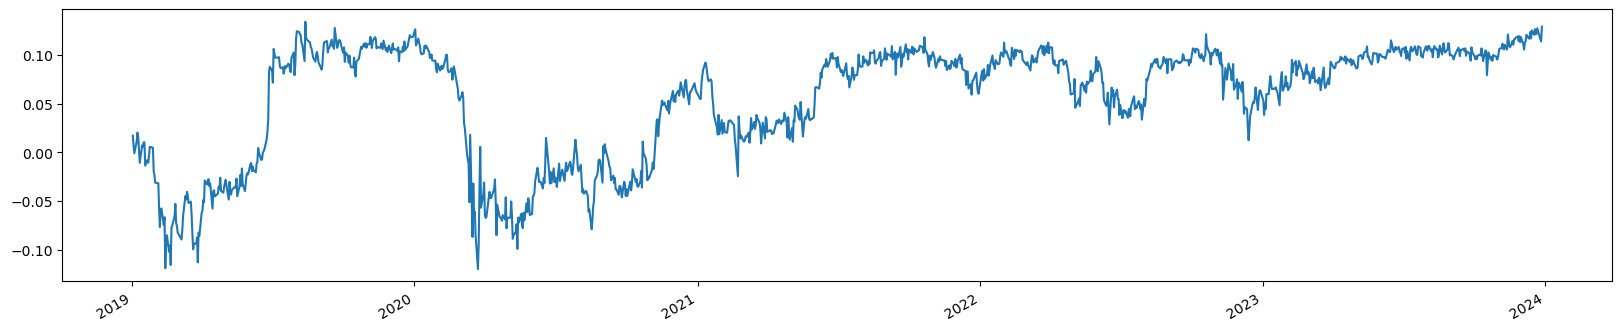

In [50]:
res[10]["returns-ols"].resid.cumsum().plot(figsize=(20, 4))